# **Assignment 9** 

## Build the following network:

1. That takes a CIFAR10 image (32x32x3)
2. Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 | 3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)
3. Apply GAP and get 1x1x48, call this X
4. Create a block called ULTIMUS that:
  - Creates 3 FC layers called K, Q and V such that:
    - X\*K = 48*48x8 > 8
    - X\*Q = 48*48x8 > 8 
    - X\*V = 48*48x8 > 8 
  - then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
  - then Z = V\*AM = 8*8 > 8
  - then another FC layer called Out that:
    - Z\*Out = 8*8x48 > 48
5. Repeat this Ultimus block 4 times
6. Then add final FC layer that converts 48 to 10 and sends it to the loss function.
7. Model would look like this C>C>C>U>U>U>U>FFC>Loss
8. Train the model for 24 epochs using the OCP that I wrote in class. Use ADAM as an optimizer. 
9. Submit the link and answer the questions on the assignment page:
  - Share the link to the main repo (must have Assignment 7/8/9 model7/8/9.py files (or similarly named))
  - Share the code of model9.py
  - Copy and paste the Training Log
  - Copy and paste the training and validation loss chart

In [ ]:
!rm -rf ./*
!git clone https://github.com/abhyuditjain/pytorch-models
!mv pytorch-models/* ./
!rm -rf pytorch-models
!pip install -r requirements.txt

Cloning into 'pytorch-models'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 166 (delta 106), reused 111 (delta 51), pack-reused 0
Receiving objects: 100% (166/166), 51.65 KiB | 2.15 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 35.5 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=ed7cfec1f459ecdc4ad3c348897a66c0457a3d8f2ff50a1add3c04a98111fed6
  Stored in directory: /ro

In [ ]:
import copy
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from utils.dataloader import Cifar10DataLoader
from models.model9 import TransformerModel
from utils.transforms import CustomResnetTransforms, DefaultTransforms
from utils.trainer import Trainer
from utils.tester import Tester
from utils.summary import print_summary
from utils.utils import show_misclassified_images, show_training_images, denormalize, show_grad_cam, show_losses_and_accuracies, get_module_by_name, get_device, show_lr_history
from main import train_model, get_lr, run # remove this

In [ ]:
is_cuda_available, device = get_device()
print_summary(TransformerModel(), device, input_size=(3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
TransformerModel (TransformerModel)      --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Sequential (conv_block)                --                        [20, 3, 32, 32]           [20, 48, 32, 32]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 3, 32, 32]           [20, 16, 32, 32]          448                       9,175,040                 True
│    └─BatchNorm2d (1)                   --                        [20, 16, 32, 32]          [20, 16, 32, 32]          32                        640                       True
│    └─ReLU (2)                          --                        [20, 16, 32, 32]          [20, 16, 32, 32]      

In [ ]:
cifar10 = Cifar10DataLoader(CustomResnetTransforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


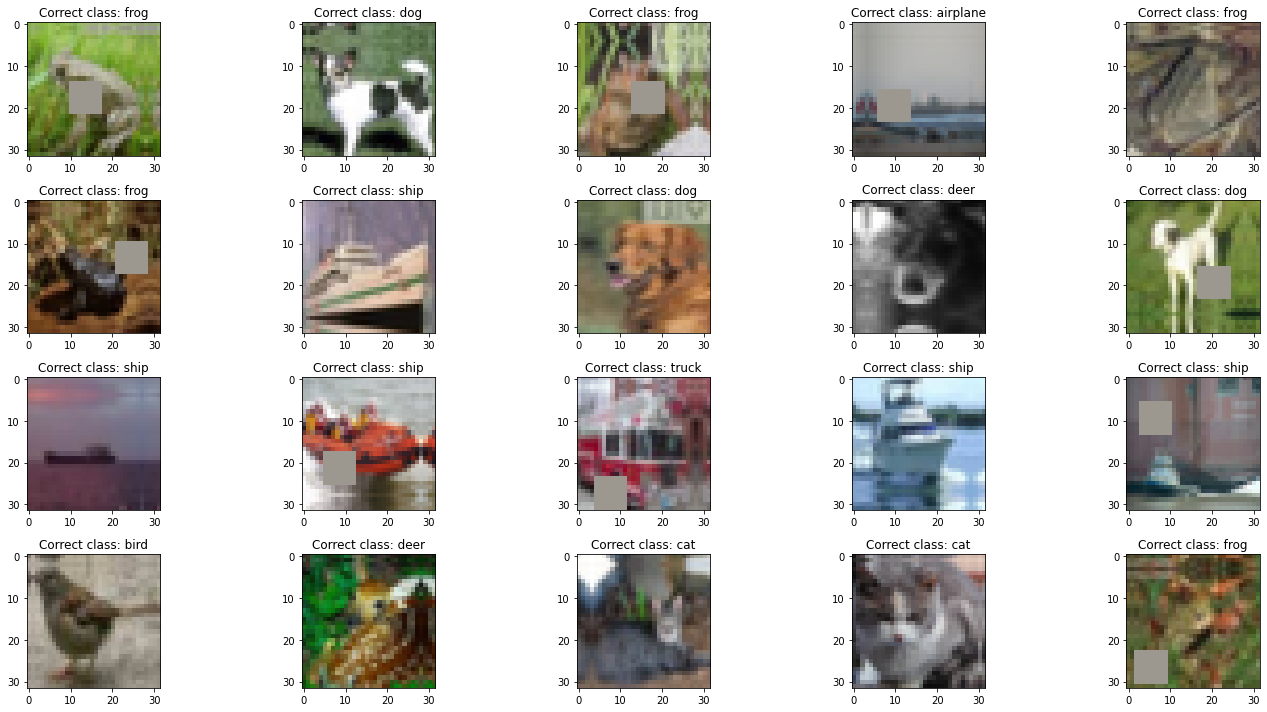

In [ ]:
show_training_images(train_loader, 20, cifar10.classes)

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.93E-04


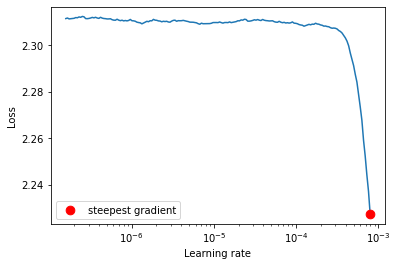

Min Loss = 2.189714883543986, Max LR = 0.001


In [ ]:
model = TransformerModel()

cifar10_exp = Cifar10DataLoader(DefaultTransforms, 512, is_cuda_available, shuffle=False)
train_loader_exp = cifar10_exp.get_loader(train=True)

optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

min_loss, max_lr = get_lr(
        model=model,
        train_loader=train_loader_exp,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        end_lr=0.001,
        num_iter=200,
    )

In [ ]:
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5 / EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=1000,
        anneal_strategy="linear",
    )

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(trainer, tester, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False)

EPOCH = 1 | LR = 0.00020840490797546012 | Loss = 2.30 | Batch = 97 | Accuracy = 10.01: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]


Test set: Average loss: 0.0046, Accuracy: 1085/10000 (10.85%)



EPOCH = 2 | LR = 0.0004068098159509203 | Loss = 1.95 | Batch = 97 | Accuracy = 18.53: 100%|██████████| 98/98 [00:16<00:00,  6.03it/s]


Test set: Average loss: 0.0039, Accuracy: 2197/10000 (21.97%)



EPOCH = 3 | LR = 0.0006052147239263804 | Loss = 1.88 | Batch = 97 | Accuracy = 21.81: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]


Test set: Average loss: 0.0038, Accuracy: 2267/10000 (22.67%)



EPOCH = 4 | LR = 0.0008036196319018405 | Loss = 1.91 | Batch = 97 | Accuracy = 22.90: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]


Test set: Average loss: 0.0038, Accuracy: 2273/10000 (22.73%)



EPOCH = 5 | LR = 0.000999462948442535 | Loss = 1.86 | Batch = 97 | Accuracy = 24.23: 100%|██████████| 98/98 [00:16<00:00,  6.09it/s]


Test set: Average loss: 0.0037, Accuracy: 2438/10000 (24.38%)



EPOCH = 6 | LR = 0.000946831895810956 | Loss = 1.83 | Batch = 97 | Accuracy = 26.08: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]


Test set: Average loss: 0.0036, Accuracy: 2678/10000 (26.78%)



EPOCH = 7 | LR = 0.0008942008431793771 | Loss = 1.80 | Batch = 97 | Accuracy = 28.40: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]


Test set: Average loss: 0.0035, Accuracy: 3065/10000 (30.65%)



EPOCH = 8 | LR = 0.0008415697905477981 | Loss = 1.65 | Batch = 97 | Accuracy = 31.55: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]


Test set: Average loss: 0.0035, Accuracy: 3274/10000 (32.74%)



EPOCH = 9 | LR = 0.0007889387379162191 | Loss = 1.69 | Batch = 97 | Accuracy = 34.42: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]


Test set: Average loss: 0.0032, Accuracy: 3650/10000 (36.50%)



EPOCH = 10 | LR = 0.0007363076852846401 | Loss = 1.56 | Batch = 97 | Accuracy = 35.81: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]


Test set: Average loss: 0.0032, Accuracy: 3737/10000 (37.37%)



EPOCH = 11 | LR = 0.0006836766326530613 | Loss = 1.61 | Batch = 97 | Accuracy = 37.97: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]


Test set: Average loss: 0.0031, Accuracy: 3903/10000 (39.03%)



EPOCH = 12 | LR = 0.0006310455800214822 | Loss = 1.54 | Batch = 97 | Accuracy = 39.10: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]


Test set: Average loss: 0.0031, Accuracy: 3996/10000 (39.96%)



EPOCH = 13 | LR = 0.0005784145273899033 | Loss = 1.49 | Batch = 97 | Accuracy = 40.34: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]


Test set: Average loss: 0.0030, Accuracy: 4168/10000 (41.68%)



EPOCH = 14 | LR = 0.0005257834747583244 | Loss = 1.53 | Batch = 97 | Accuracy = 41.09: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]


Test set: Average loss: 0.0030, Accuracy: 4094/10000 (40.94%)



EPOCH = 15 | LR = 0.00047315242212674536 | Loss = 1.42 | Batch = 97 | Accuracy = 41.69: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]


Test set: Average loss: 0.0030, Accuracy: 4196/10000 (41.96%)



EPOCH = 16 | LR = 0.00042052136949516654 | Loss = 1.47 | Batch = 97 | Accuracy = 42.14: 100%|██████████| 98/98 [00:15<00:00,  6.33it/s]


Test set: Average loss: 0.0029, Accuracy: 4335/10000 (43.35%)



EPOCH = 17 | LR = 0.0003678903168635875 | Loss = 1.46 | Batch = 97 | Accuracy = 42.94: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]


Test set: Average loss: 0.0029, Accuracy: 4358/10000 (43.58%)



EPOCH = 18 | LR = 0.0003152592642320085 | Loss = 1.43 | Batch = 97 | Accuracy = 43.49: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]


Test set: Average loss: 0.0030, Accuracy: 4263/10000 (42.63%)



EPOCH = 19 | LR = 0.00026262821160042966 | Loss = 1.51 | Batch = 97 | Accuracy = 43.87: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]


Test set: Average loss: 0.0029, Accuracy: 4424/10000 (44.24%)



EPOCH = 20 | LR = 0.00020999715896885063 | Loss = 1.46 | Batch = 97 | Accuracy = 44.27: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]


Test set: Average loss: 0.0028, Accuracy: 4575/10000 (45.75%)



EPOCH = 21 | LR = 0.0001573661063372717 | Loss = 1.39 | Batch = 97 | Accuracy = 44.67: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]


Test set: Average loss: 0.0029, Accuracy: 4478/10000 (44.78%)



EPOCH = 22 | LR = 0.00010473505370569268 | Loss = 1.43 | Batch = 97 | Accuracy = 45.11: 100%|██████████| 98/98 [00:15<00:00,  6.16it/s]


Test set: Average loss: 0.0028, Accuracy: 4602/10000 (46.02%)



EPOCH = 23 | LR = 5.210400107411386e-05 | Loss = 1.42 | Batch = 97 | Accuracy = 45.36: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]


Test set: Average loss: 0.0028, Accuracy: 4587/10000 (45.87%)



EPOCH = 24 | LR = -5.270515574650608e-07 | Loss = 1.34 | Batch = 97 | Accuracy = 45.56: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]


Test set: Average loss: 0.0028, Accuracy: 4577/10000 (45.77%)



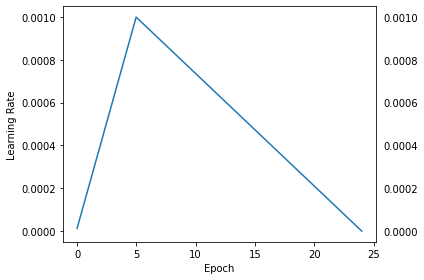

In [ ]:
show_lr_history(trainer, EPOCHS)

In [ ]:
print(f"Max LR = {max(trainer.lr_history)}")
print(f"Min LR = {min(trainer.lr_history)}")

Max LR = 0.001
Min LR = -5.270515574650608e-07


# Get misclassified images from Tester

In [ ]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

# Show misclassified images

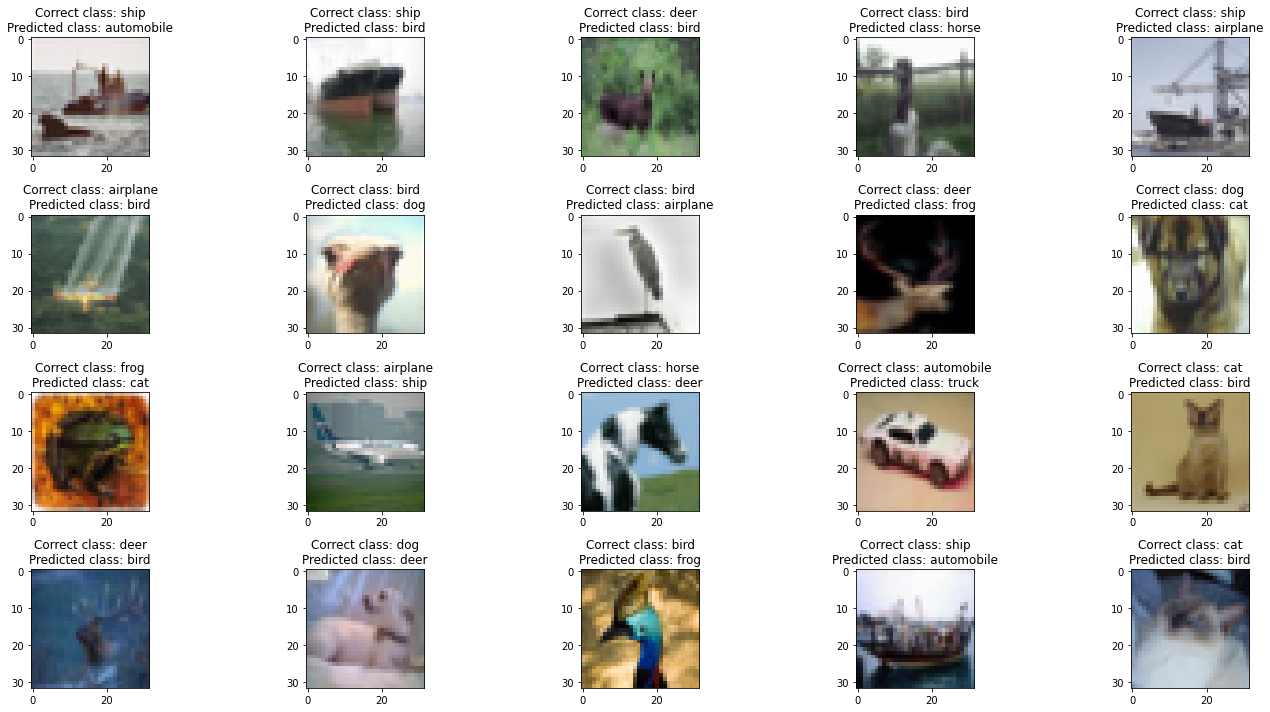

In [ ]:
show_misclassified_images(misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes)

# Loss and Accuracy Graphs for Training and Testing

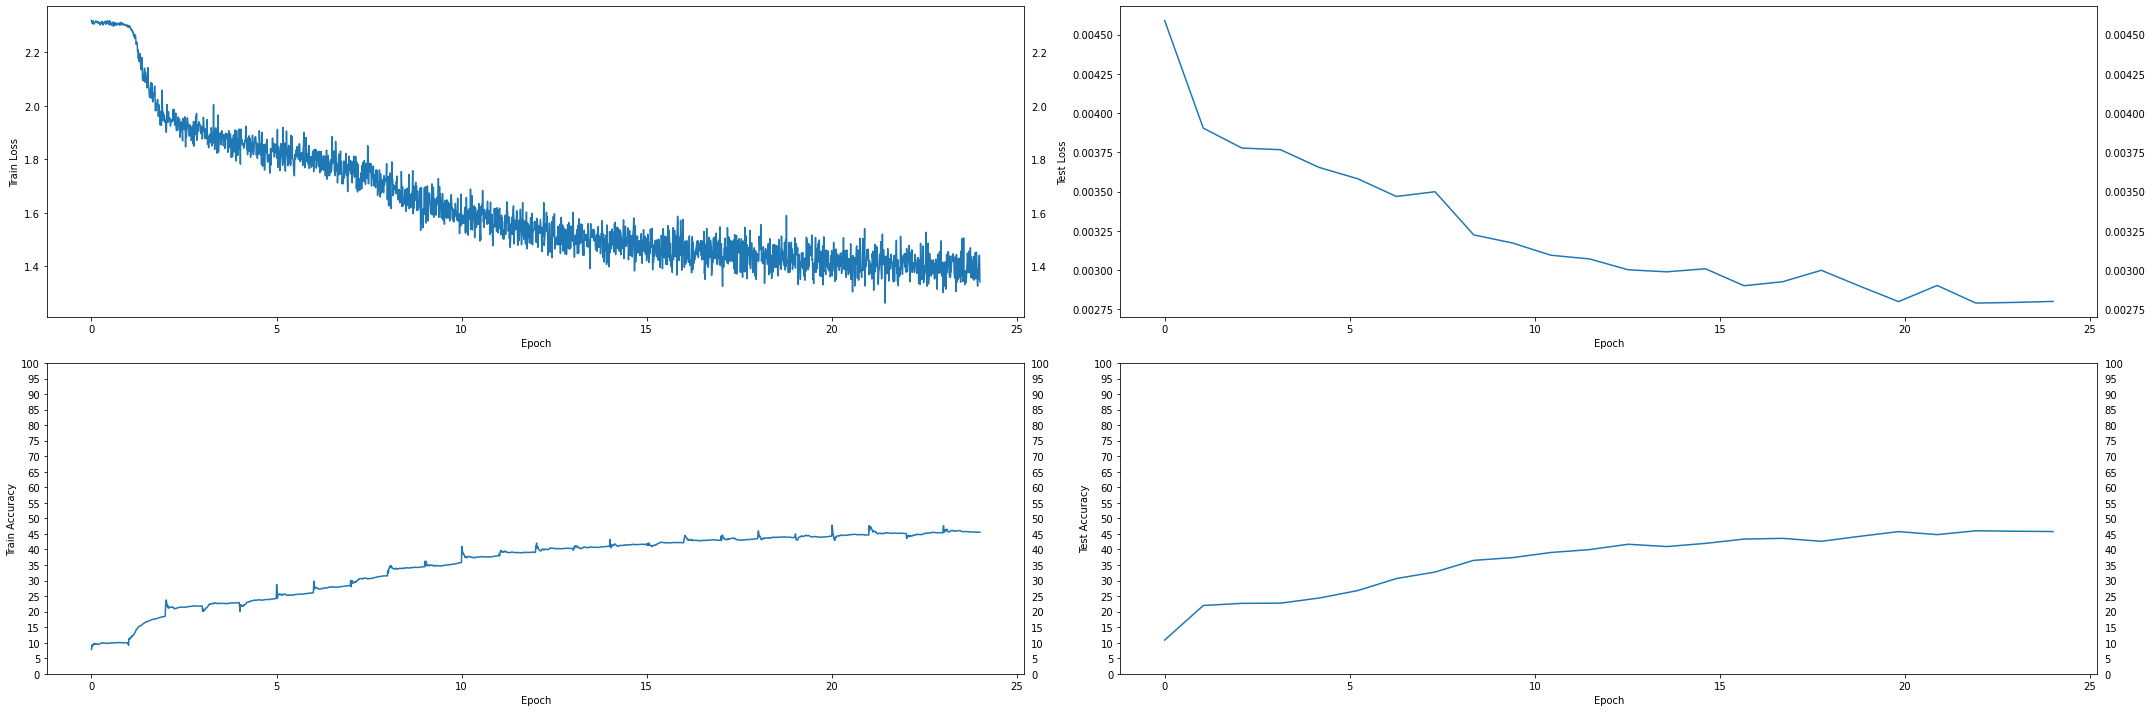

In [ ]:
show_losses_and_accuracies(trainer, tester, EPOCHS)